In [1]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers import RobertaTokenizer, XLNetTokenizer
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
DEVICE = 'cpu'

In [4]:
from tqdm import tqdm
tqdm.pandas()

In [5]:
ls ../mnt/inputs/nes_info/

ContextualWordEmbsAug_sub_df.pkl  question_body_grp_count.csv
aug_rows.pkl                      question_body_grp_count.pkl
aug_train_1.pkl                   trn_df.pkl


In [6]:
trn_df = pd.read_pickle('../mnt/inputs/nes_info/trn_df.pkl')
tst_df = pd.read_csv('../mnt/inputs/origin/test.csv')

all_df = pd.concat([trn_df[tst_df.columns], tst_df], axis=0).reset_index(drop=True)
display(trn_df.shape, trn_df.head())

(6079, 42)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,question_body_le
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,143
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,857
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,2285
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,155
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,835


In [6]:
trn_df.iloc[0].question_body.split('.')

['After playing around with macro photography on-the-cheap (read: reversed lens, rev',
 ' lens mounted on a straight lens, passive extension tubes), I would like to get further with this',
 ' The problems with the techniques I used is that focus is manual and aperture control is problematic at best',
 ' This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects',
 ' I believe that for this, autofocus and settable aperture will be of great help',
 '\n\nSo, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens',
 ' An alternative is the electrical extension tubes',
 '\n\nExcept for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2',
 '8) instead of a macro lens?\n']

In [11]:
# 改行も split されてそう
# まぁ改行は無視でよいか...？
for i, j in zip(trn_df.iloc[0].question_body.split(' '), trn_df.iloc[0].question_body.split()):
    # print(i == j)
    if i != j:
        print(i, j)

help.

So, help.
one So,
obvious one
but obvious
expensive but
option expensive
is option
a is
macro a
lens macro
(say, lens
EF (say,
100mm EF
Macro) 100mm
However, Macro)
I However,
am I
not am
really not
interested really
in interested
yet in
another yet
prime another
lens. prime
An lens.
alternative An
is alternative
the is
electrical the
extension electrical
tubes.

Except extension
for tubes.
maximum Except
focusing for
distance, maximum
what focusing
am distance,
I what
losing am
when I
using losing
tubes when
(coupled using
with tubes
a (coupled
fine with
lens, a
say fine
EF70-200/2.8) lens,
instead say
of EF70-200/2.8)
a instead
macro of
lens?
 a


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_tokenizer_keys = set(tokenizer.vocab.keys())
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#roberta_tokenizer_keys = set(tokenizer.vocab.keys())
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
#xlnet_tokenizer_keys = set(tokenizer.vocab.keys())

In [34]:
bert_tokenizer_keys

{'##春',
 '##elles',
 'overlooking',
 'wonder',
 'testing',
 'hugely',
 'hometown',
 'yorkshire',
 'experiment',
 'vine',
 'chung',
 'partly',
 'reciprocal',
 'α',
 'israel',
 'skins',
 'academia',
 '##d',
 'cerebral',
 'residents',
 'prairie',
 '##athlon',
 'keeping',
 'truths',
 'arrived',
 '##heimer',
 'astronaut',
 'married',
 '1931',
 '##博',
 'shoe',
 'paying',
 'dew',
 'northern',
 'inscriptions',
 'dona',
 '##gie',
 'dow',
 'paul',
 'monkey',
 'calais',
 '##oja',
 '##imi',
 'sanchez',
 '1640',
 'electrode',
 '##ito',
 'all',
 'someone',
 '##pon',
 '[unused373]',
 'newspaper',
 'copa',
 'chalk',
 'portions',
 'elementary',
 '##lter',
 'bomb',
 'mounted',
 'bread',
 'cartoonist',
 '##drome',
 'sham',
 'ा',
 'yep',
 'instant',
 '[SEP]',
 'unstable',
 'spd',
 'darrell',
 'kelly',
 'greaves',
 '1737',
 'cb',
 'clubhouse',
 'outcome',
 '##示',
 'would',
 '##„',
 '##arth',
 'plotted',
 'shakes',
 'armies',
 '##rling',
 'intimidation',
 'dedicated',
 'reminder',
 'potential',
 '##ikh',
 '

In [39]:
trn_df.iloc[0]['answer']

['i',
 'just',
 'got',
 'extension',
 'tubes,',
 'so',
 "here's",
 'the',
 'skinny.',
 '...what',
 'am',
 'i',
 'losing',
 'when',
 'using',
 'tubes...?',
 'a',
 'very',
 'considerable',
 'amount',
 'of',
 'light!',
 'increasing',
 'that',
 'distance',
 'from',
 'the',
 'end',
 'of',
 'the',
 'lens',
 'to',
 'the',
 'sensor',
 'can',
 'cut',
 'your',
 'light',
 'several',
 'stops.',
 'combined',
 'with',
 'the',
 'fact',
 'that',
 "you'll",
 'usually',
 'shoot',
 'stopped',
 'down',
 '-',
 'expect',
 'to',
 'need',
 'to',
 'increase',
 'your',
 'iso',
 'considerably.',
 'the',
 'fact',
 'the',
 "macro's",
 'are',
 'usually',
 'considered',
 'very',
 'very',
 'sharp,',
 'although',
 'i',
 'believe',
 'that',
 '70-200mm',
 '2.8',
 'is',
 'supposed',
 'to',
 'be',
 'quite',
 'sharp.',
 'the',
 'ultra',
 'low',
 'distortion',
 'typical',
 'of',
 'many',
 'macros.',
 'i',
 "wouldn't",
 'worry',
 'too',
 'much',
 'about',
 'the',
 'bokeh',
 'since',
 'the',
 'dof',
 'will',
 'still',
 'be',


In [19]:
from collections import defaultdict

def check_converge(tokenizer_vocab_set, df):
    title_words = {}
    body_words = {}
    answer_words = {}

    for i, row in tqdm(list(df.iterrows())):
        for word in row['question_title'].casefold().split():
        # for word in row['question_title'].split():
            if word in title_words:
                title_words[word] += 1
            else:
                title_words[word] = 1
        for word in row['question_body'].casefold().split():
        # for word in row['question_body'].split():
            if word in body_words:
                body_words[word] += 1
            else:
                body_words[word] = 1
        for word in row['answer'].casefold().split():
        # for word in row['answer'].split():
            if word in answer_words:
                answer_words[word] += 1
            else:
                answer_words[word] = 1

    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    ax = axs[0]
    venn2([tokenizer_vocab_set, set(title_words.keys())], set_labels=['vocab', 'title'], ax=ax)
    ax.set_title('vocab vs title')

    ax = axs[1]
    venn2([tokenizer_vocab_set, set(body_words)], set_labels=['vocab', 'body'], ax=ax)
    ax.set_title('vocab vs body')

    ax = axs[2]
    venn2([tokenizer_vocab_set, set(answer_words)], set_labels=['vocab', 'answer'], ax=ax)
    ax.set_title('vocab vs answer')
    
    plt.show()
    return title_words, body_words, answer_words

100%|██████████| 6079/6079 [00:00<00:00, 9639.43it/s]


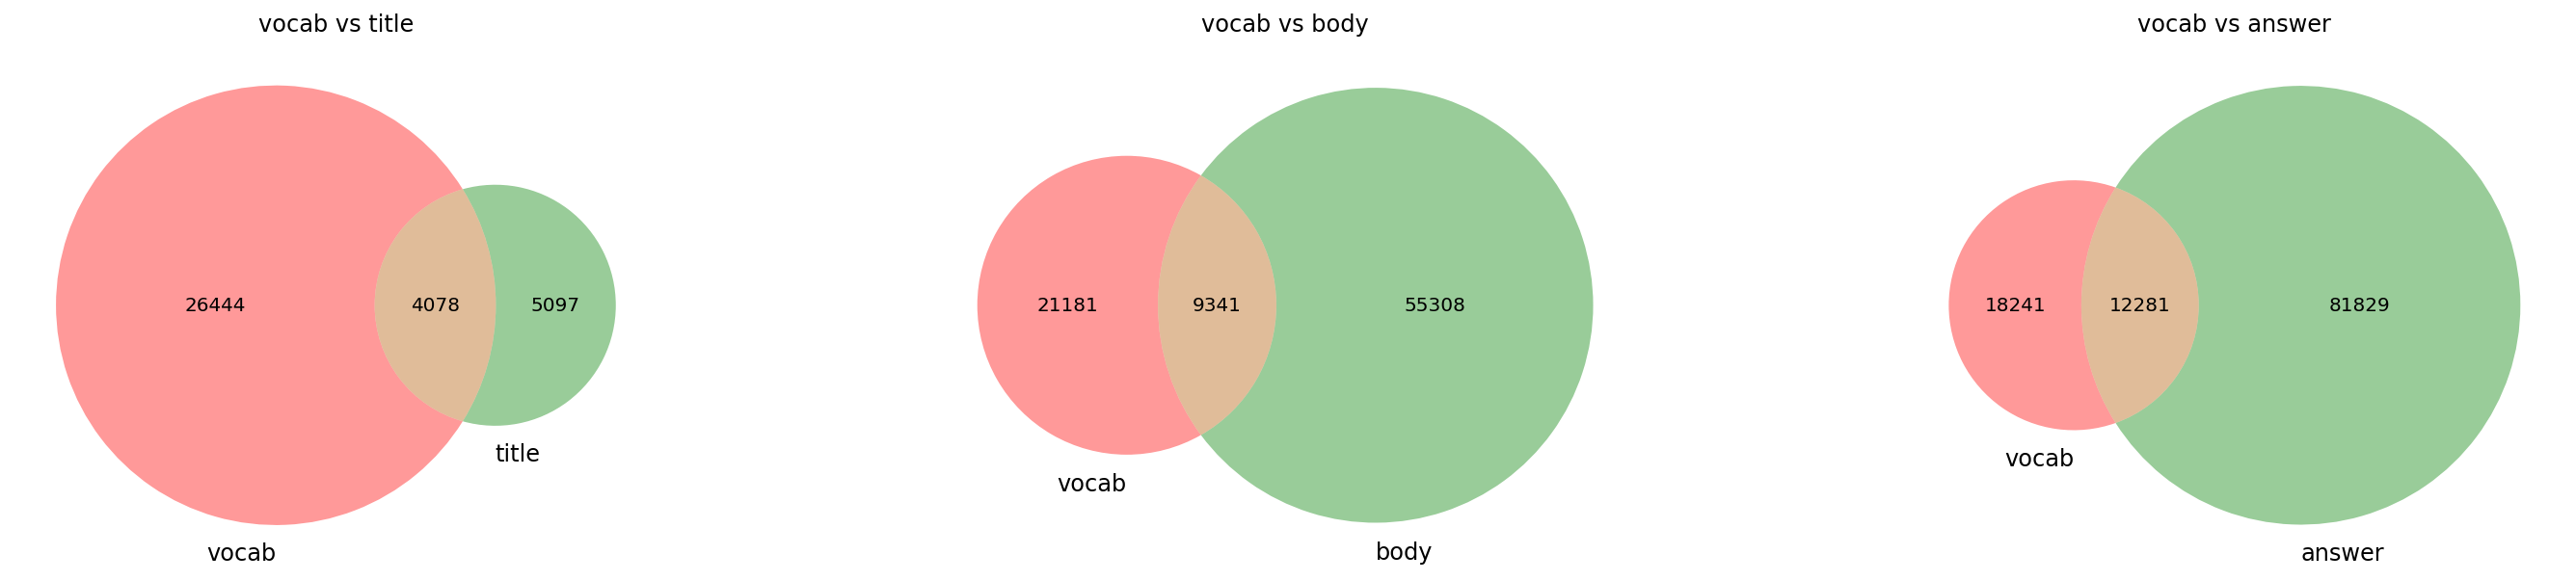

In [59]:
check_converge(bert_tokenizer_keys, trn_df)

## kernel1 をそのまま使ってみる
 - https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

In [10]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
     '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\n', '\xa0', '\t',
     '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
     '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
     '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’'+''.join(puncts):
        x = x.replace(punct, '')
    return x

In [71]:
trn_df['question_title'] = trn_df['question_title'].progress_apply(lambda x: clean_text(x))
trn_df['question_body'] = trn_df['question_body'].progress_apply(lambda x: clean_text(x))
trn_df['answer'] = trn_df['answer'].progress_apply(lambda x: clean_text(x))


100%|██████████| 6079/6079 [00:00<00:00, 19912.36it/s]

100%|██████████| 6079/6079 [00:00<00:00, 9832.44it/s]

100%|██████████| 6079/6079 [00:00<00:00, 9905.50it/s] 



100%|██████████| 6079/6079 [00:00<00:00, 9277.96it/s]


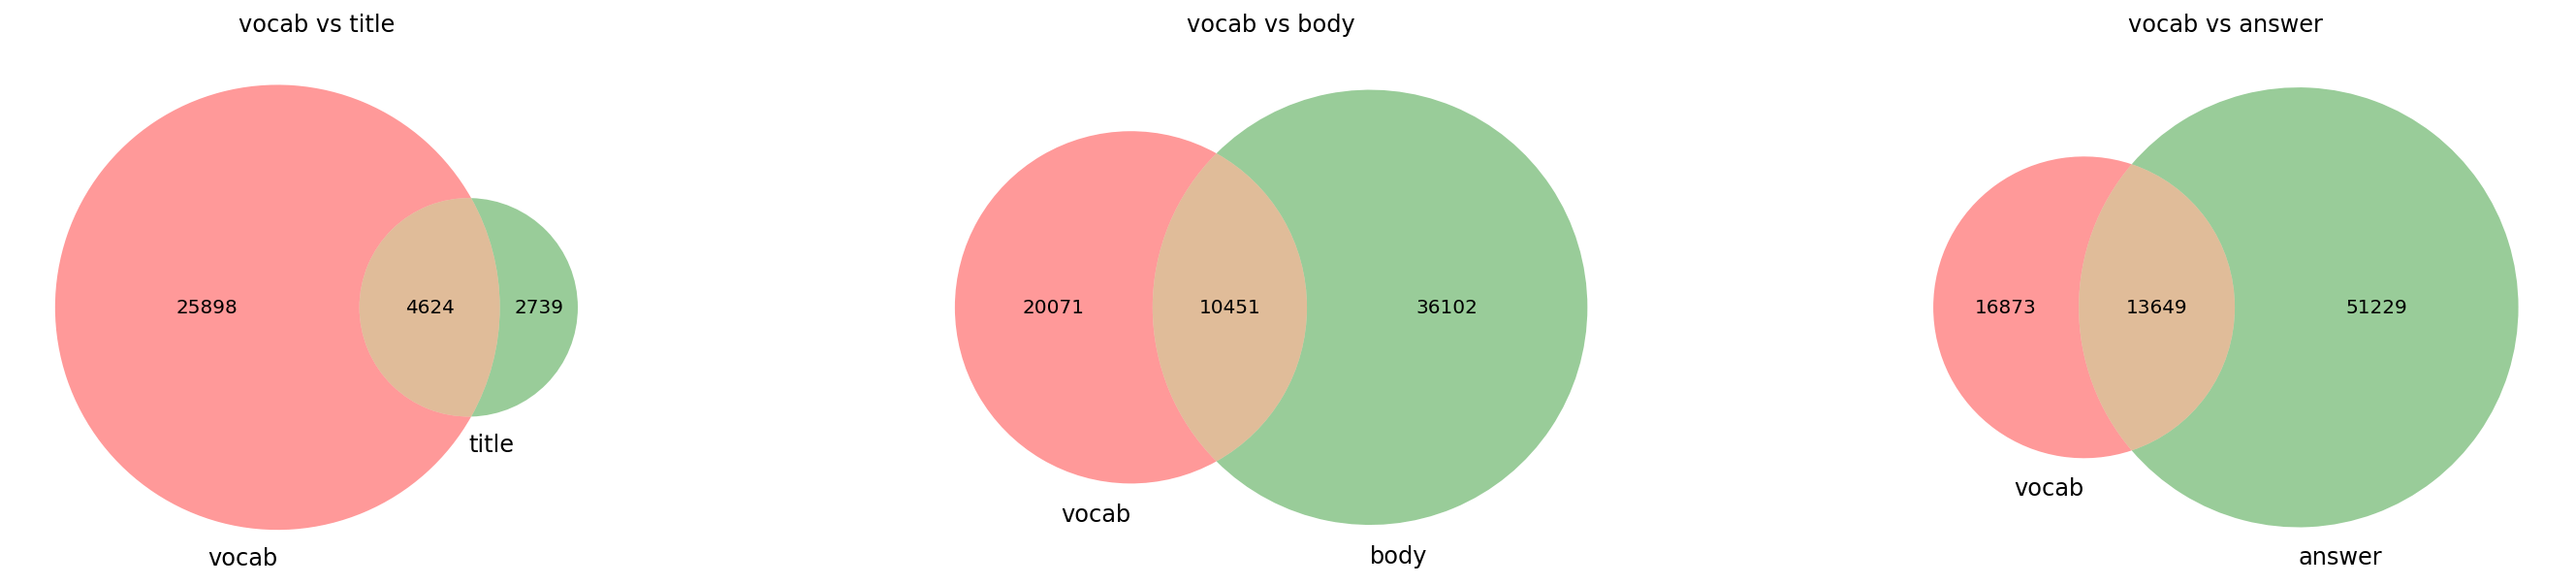

In [72]:
check_converge(bert_tokenizer_keys, trn_df)

In [11]:
import re

def clean_numbers(x):
    x = re.sub('[0-9]{8,}', '########', x)
    x = re.sub('[0-9]{7,}', '#######', x)
    x = re.sub('[0-9]{6,}', '######', x)
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [66]:
trn_df['question_title'] = trn_df['question_title'].progress_apply(lambda x: clean_numbers(x))
trn_df['question_body'] = trn_df['question_body'].progress_apply(lambda x: clean_numbers(x))
trn_df['answer'] = trn_df['answer'].progress_apply(lambda x: clean_numbers(x))


100%|██████████| 6079/6079 [00:00<00:00, 36791.72it/s]

100%|██████████| 6079/6079 [00:01<00:00, 4753.21it/s]

100%|██████████| 6079/6079 [00:01<00:00, 4667.44it/s]



100%|██████████| 6079/6079 [00:00<00:00, 9591.62it/s]


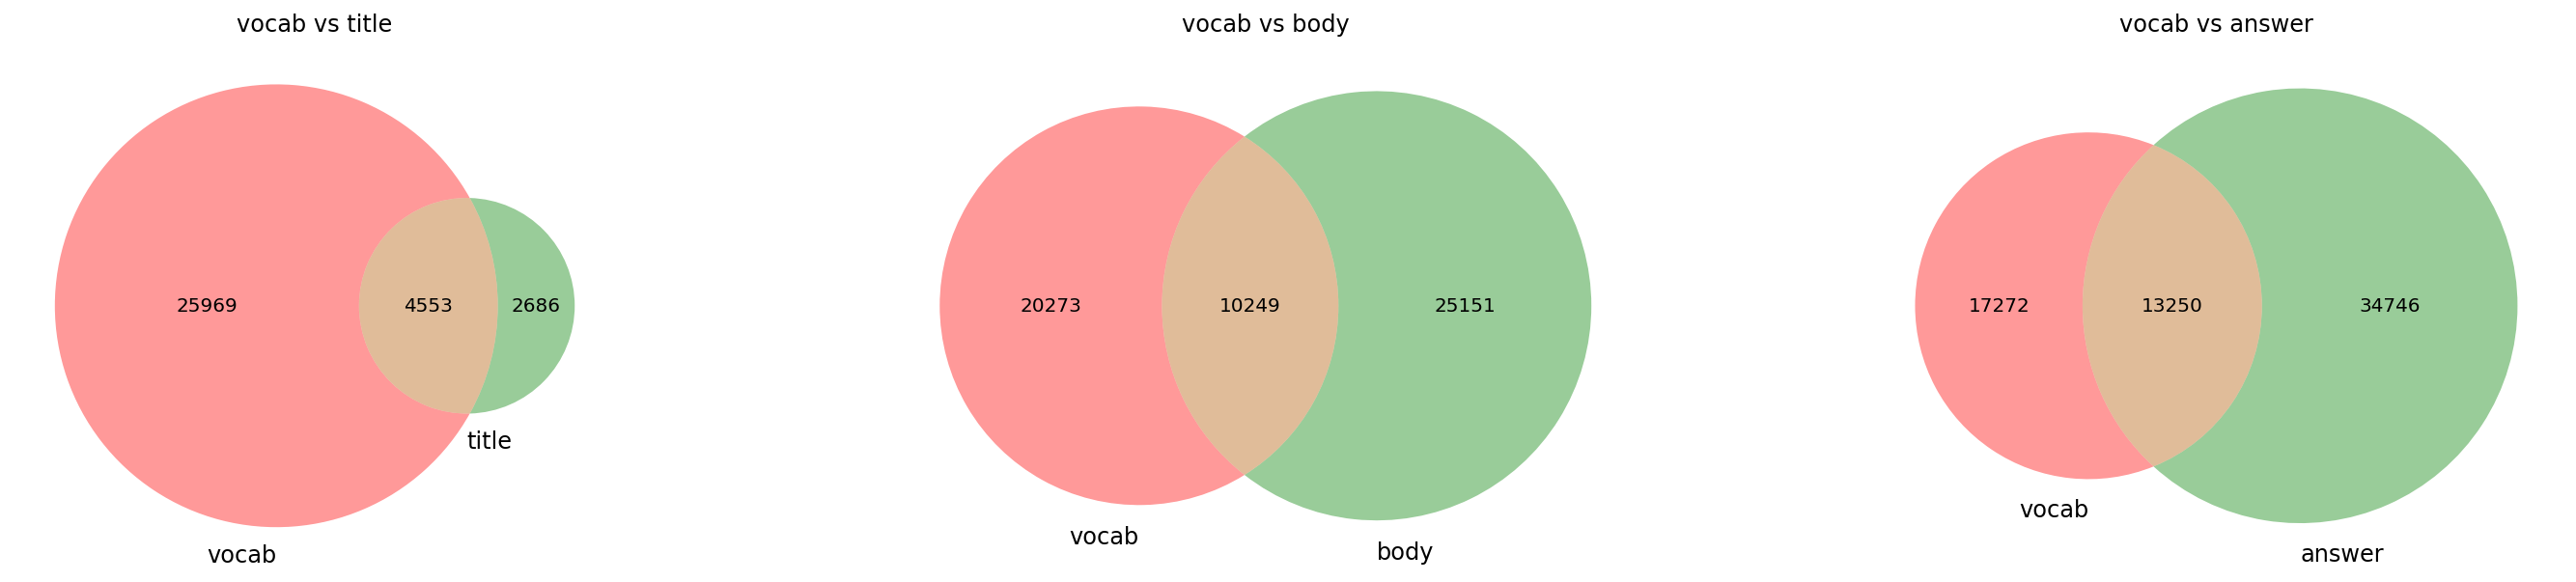

In [67]:
# これはやらないほうが良さそう
check_converge(bert_tokenizer_keys, trn_df)

In [68]:
trn_df = pd.read_pickle('../mnt/inputs/nes_info/trn_df.pkl')

In [69]:
trn_df['question_title'] = trn_df['question_title'].progress_apply(lambda x: clean_text(x))
trn_df['question_body'] = trn_df['question_body'].progress_apply(lambda x: clean_text(x))
trn_df['answer'] = trn_df['answer'].progress_apply(lambda x: clean_text(x))


100%|██████████| 6079/6079 [00:00<00:00, 71040.18it/s]

100%|██████████| 6079/6079 [00:00<00:00, 23753.24it/s]

100%|██████████| 6079/6079 [00:00<00:00, 24100.37it/s]


## てかこれでよい？
 - https://www.kaggle.com/artgor/pytorch-approach

In [8]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\n', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))

    return df

In [75]:
trn_df = pd.read_pickle('../mnt/inputs/nes_info/trn_df.pkl')


100%|██████████| 6079/6079 [00:00<00:00, 9240.10it/s]


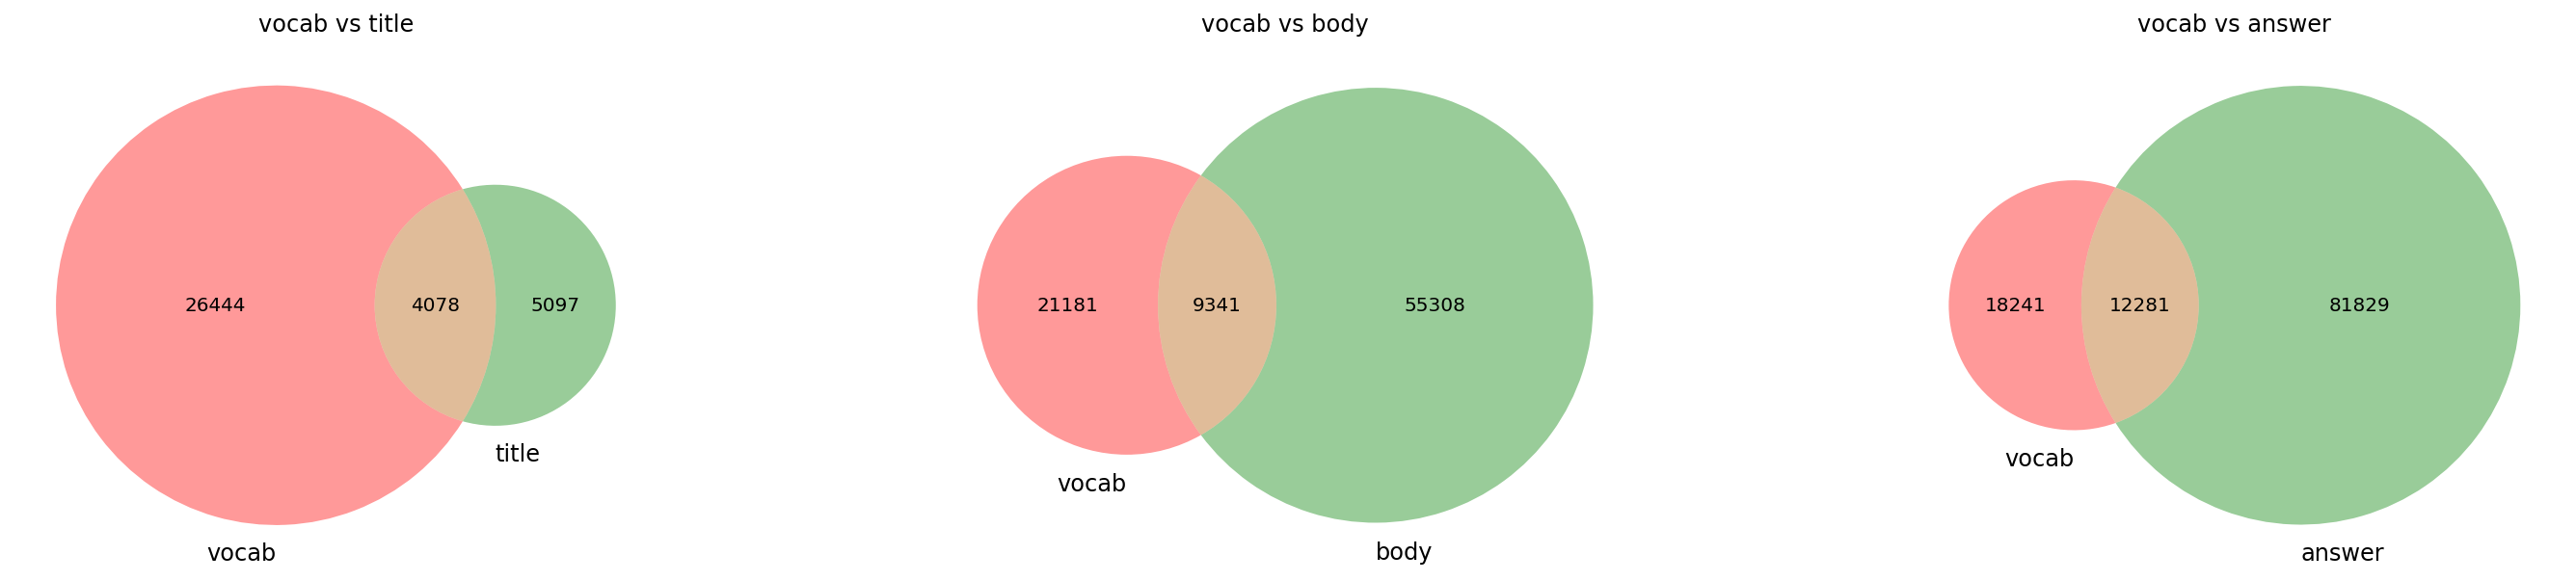

In [76]:
check_converge(bert_tokenizer_keys, trn_df)

In [77]:
trn_df = clean_data(trn_df, ['question_title', 'question_body', 'answer'])


100%|██████████| 6079/6079 [00:01<00:00, 5393.08it/s]


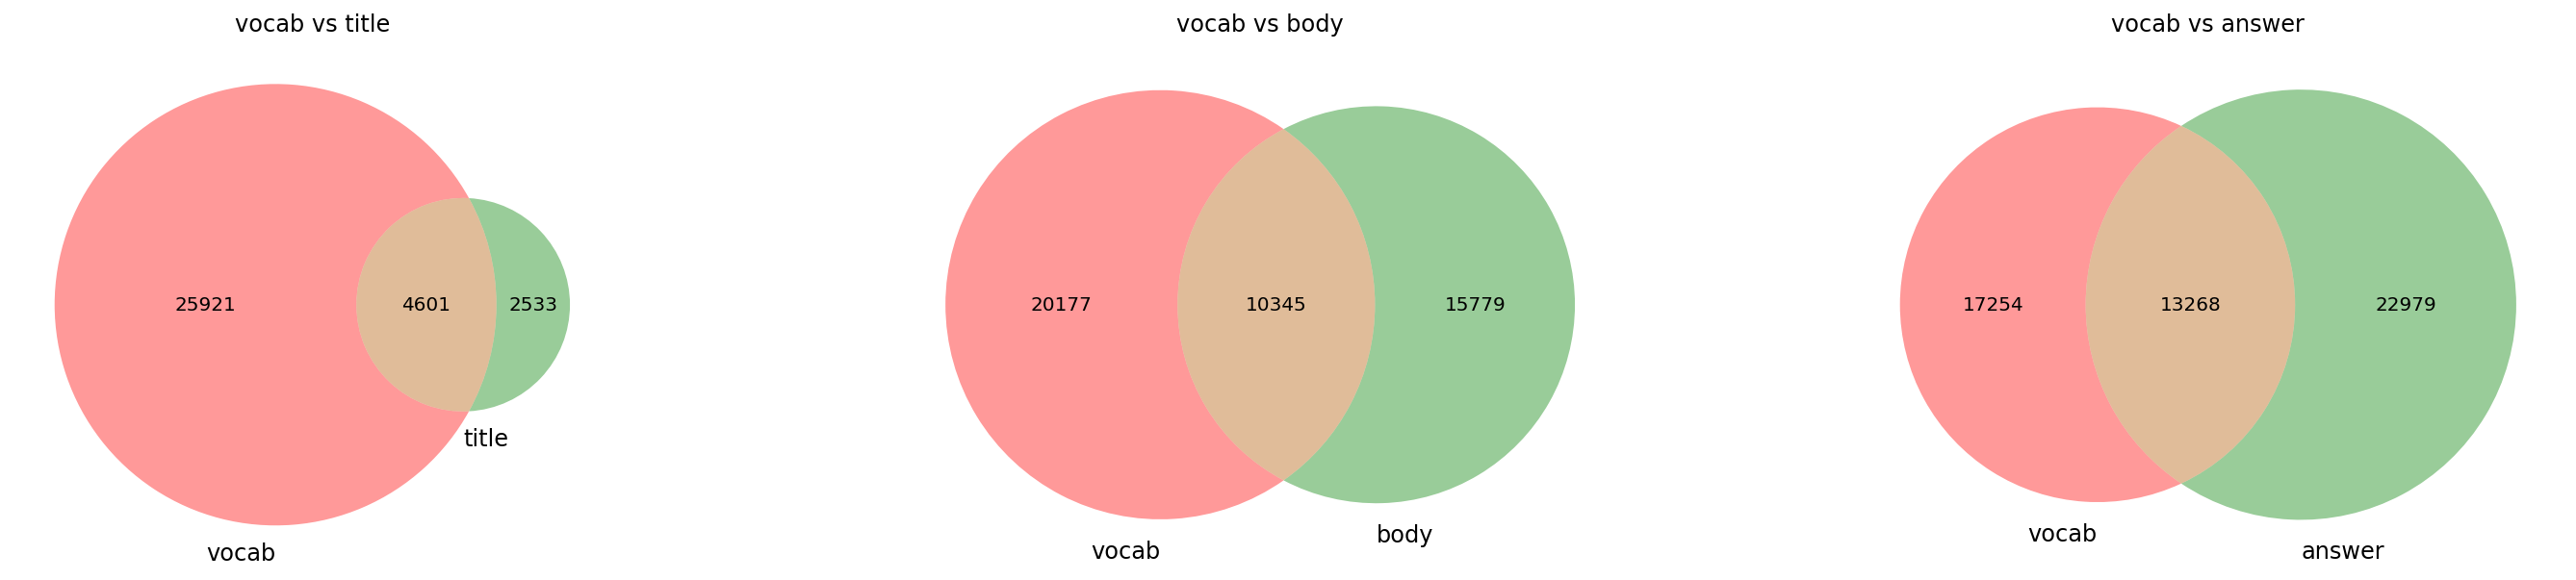

In [83]:
t, q, a = check_converge(bert_tokenizer_keys, trn_df)

In [92]:
# 専門用語が多そう, これは vocab にいれてもよいのでは？
tt = pd.Series(t).sort_values(ascending=False)
qq = pd.Series(q).sort_values(ascending=False)
aa = pd.Series(a).sort_values(ascending=False)

display(tt.loc[set(tt.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(qq.loc[set(qq.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(aa.loc[set(aa.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))

,index,0
0,jquery,54
1,javascript,51
2,ubuntu,45
3,url,34
4,mathbb,33
5,magento,31
6,sharepoint,31
7,mysql,30
8,delete,28
9,asp,26


,index,0
0,div,471
1,url,465
2,ubuntu,421
3,href,333
4,frac,326
5,js,325
6,src,223
7,mathbb,219
8,css,210
9,orf,206


,index,0
0,frac,519
1,nbsp,475
2,url,326
3,div,244
4,mathbb,206
5,sudo,167
6,usepackage,161
7,delete,154
8,cdot,153
9,config,153


## いれる単語辞典作る

100%|██████████| 6555/6555 [00:01<00:00, 5761.01it/s]


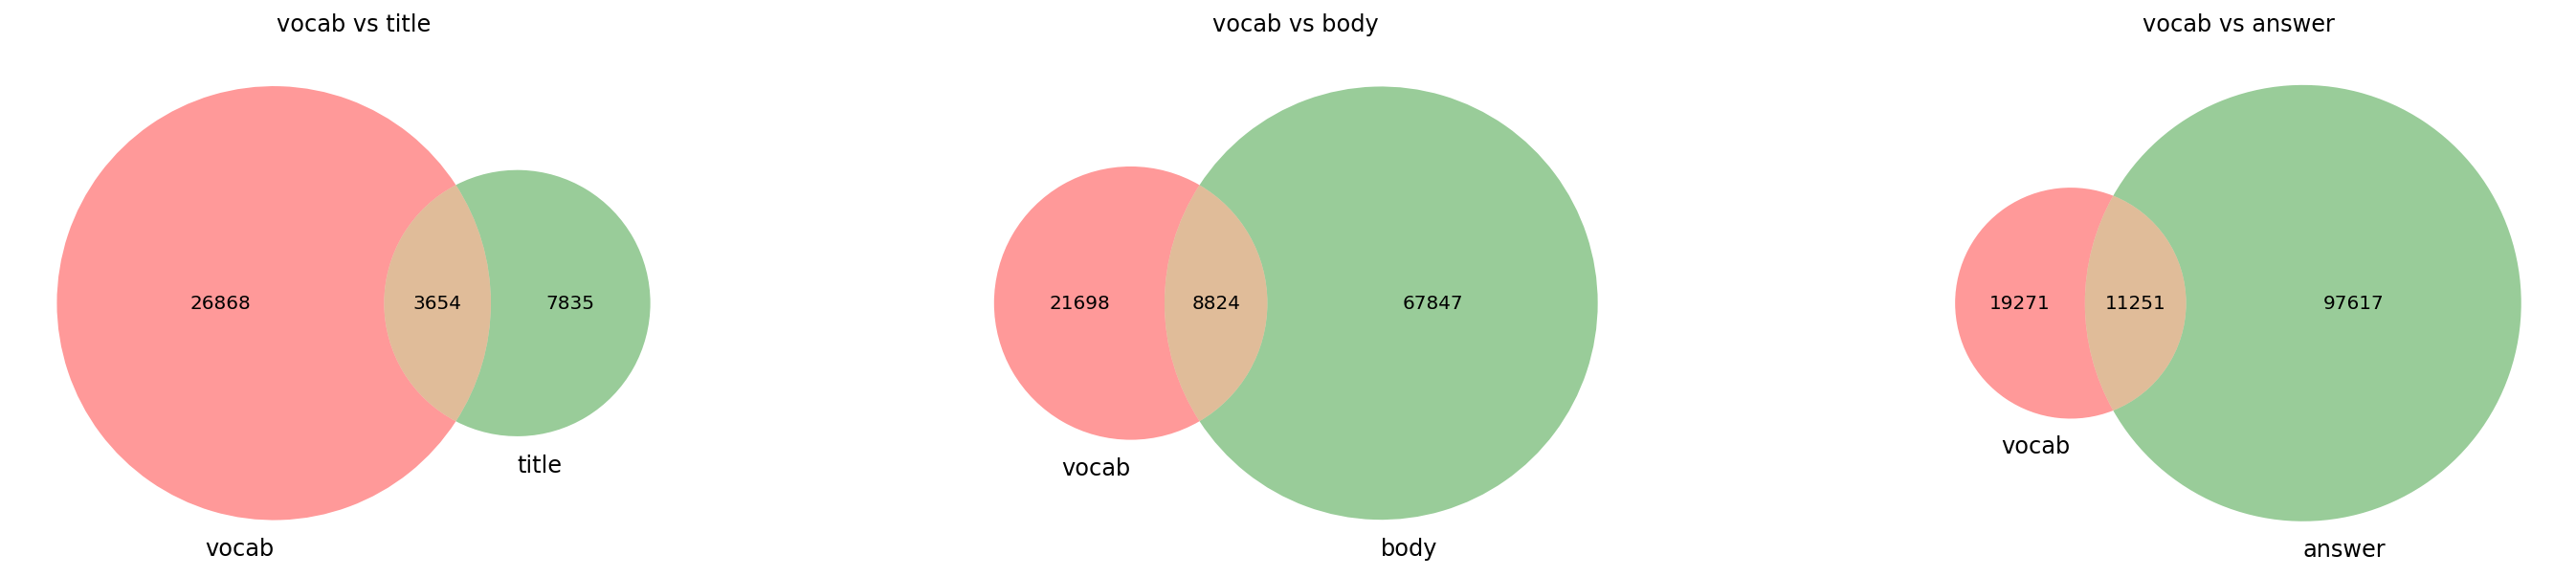

In [11]:
t, q, a = check_converge(bert_tokenizer_keys, all_df)

In [14]:
import re
all_df = clean_data(all_df, ['question_title', 'question_body', 'answer'])

100%|██████████| 6555/6555 [00:01<00:00, 4792.56it/s]


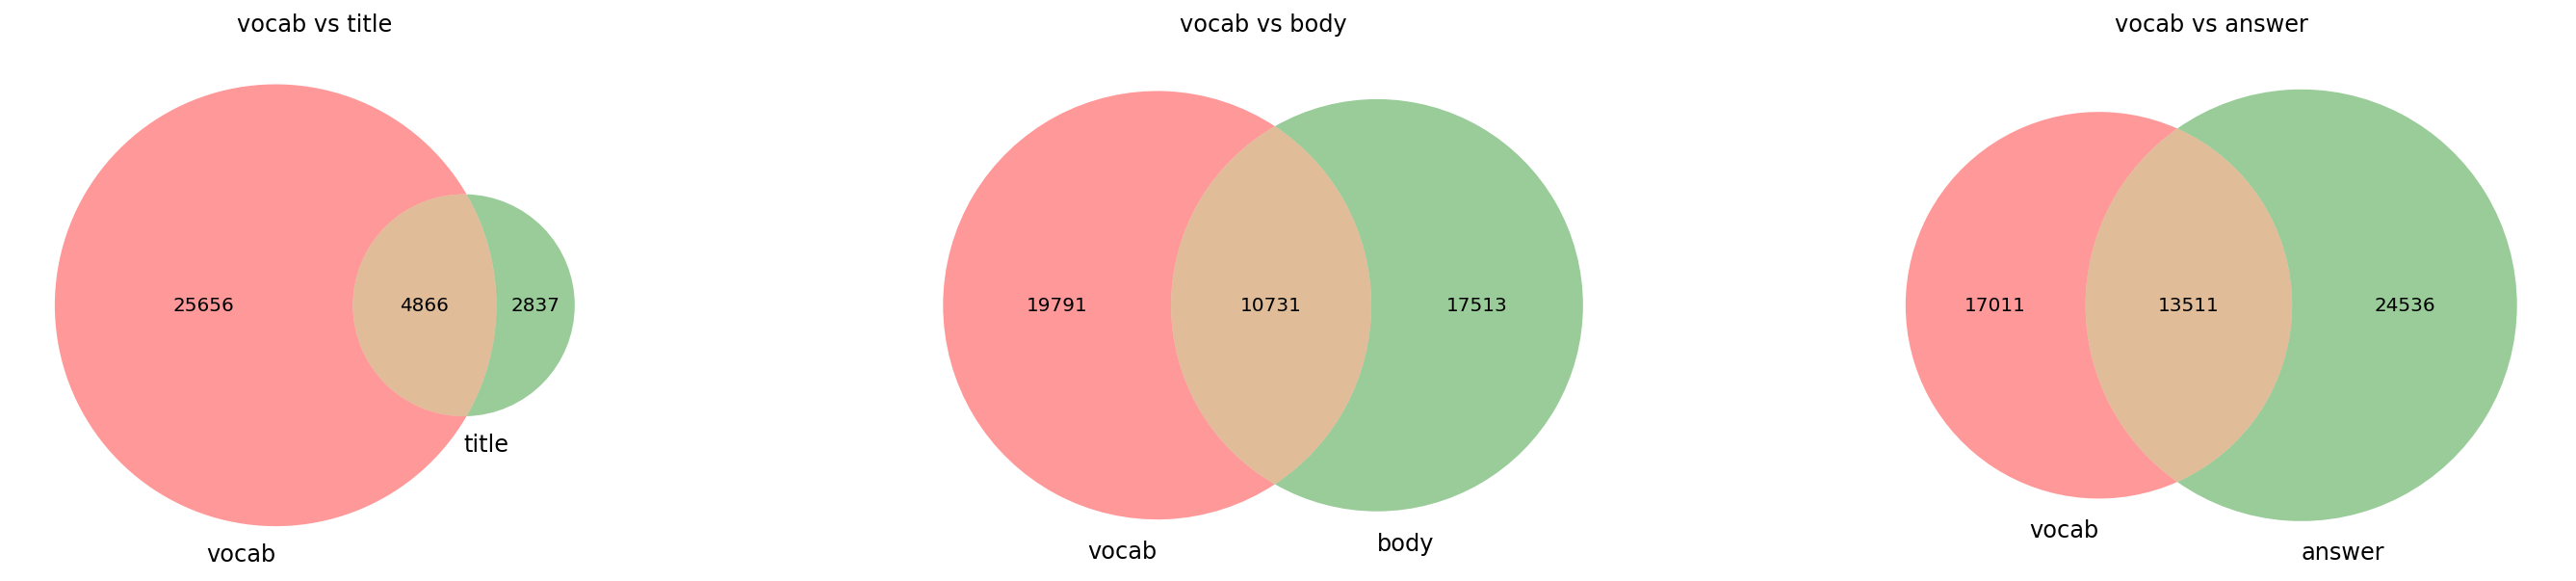

In [15]:
t, q, a = check_converge(bert_tokenizer_keys, all_df)

In [23]:
# 専門用語が多そう, これは vocab にいれてもよいのでは？
tt = pd.Series(t).sort_values(ascending=False)
qq = pd.Series(q).sort_values(ascending=False)
aa = pd.Series(a).sort_values(ascending=False)

display(tt.loc[set(tt.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(qq.loc[set(qq.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(aa.loc[set(aa.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))

,index,0
0,jquery,58
1,javascript,55
2,ubuntu,48
3,url,35
4,sharepoint,34
5,mathbb,33
6,mysql,33
7,magento,32
8,delete,31
9,asp,28


,index,0
0,url,505
1,div,504
2,ubuntu,443
3,frac,370
4,href,348
5,js,343
6,src,240
7,mathbb,238
8,0x,236
9,css,232


,index,0
0,frac,564
1,nbsp,475
2,url,343
3,div,256
4,mathbb,221
5,delete,177
6,vec,173
7,sudo,171
8,usepackage,170
9,wp,166


In [24]:
_df = pd.concat([tt.loc[set(tt.index) - bert_tokenizer_keys], qq.loc[set(qq.index) - bert_tokenizer_keys], aa.loc[set(aa.index) - bert_tokenizer_keys]], axis=0).reset_index(drop=False).reset_index(drop=True)
_df.columns = ['word', 'count']
res_df = _df.groupby('word').sum().reset_index().sort_values('count', ascending=False)
res_df

,word,count
11004,frac,939
31393,url,883
8113,div,768
30666,ubuntu,637
19336,nbsp,578
...,...,...
10120,fainter,1
10119,failsafes,1
10118,failsafe,1
22899,priming,1


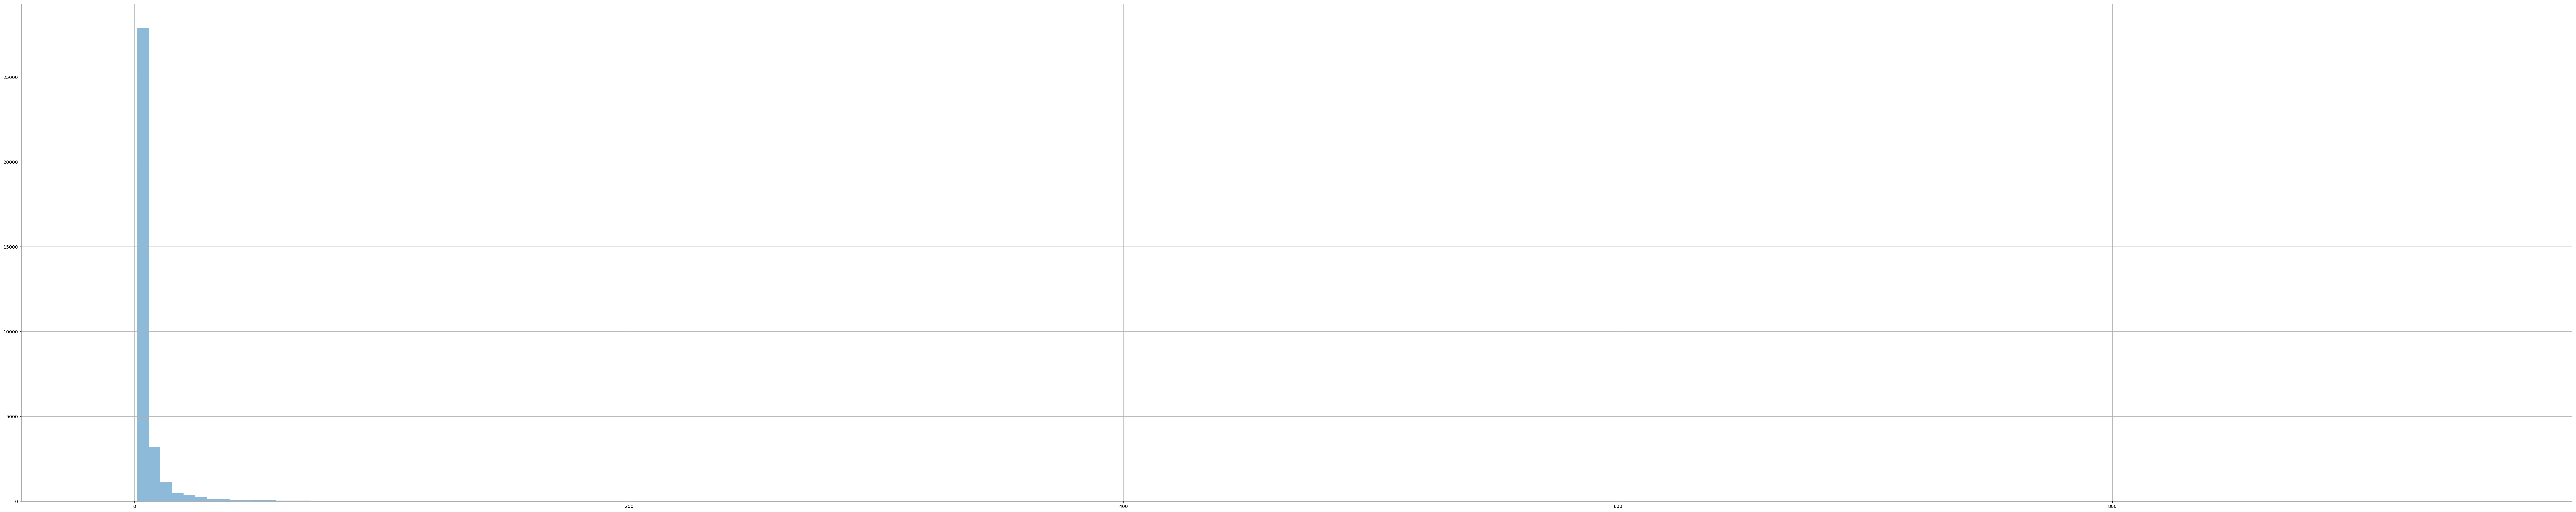

In [25]:
plt.figure(figsize=(100, 20))
res_df['count'].hist(bins=200, alpha=0.5)

In [26]:
(res_df['count'] >= 10).sum(),(res_df['count'] >= 20).sum(),(res_df['count'] >= 30).sum(),

(3410, 1435, 823)

## trn のみで見たほうが良いのでは？

In [27]:
import re
trn_df = clean_data(trn_df, ['question_title', 'question_body', 'answer'])

100%|██████████| 6079/6079 [00:01<00:00, 4588.65it/s]


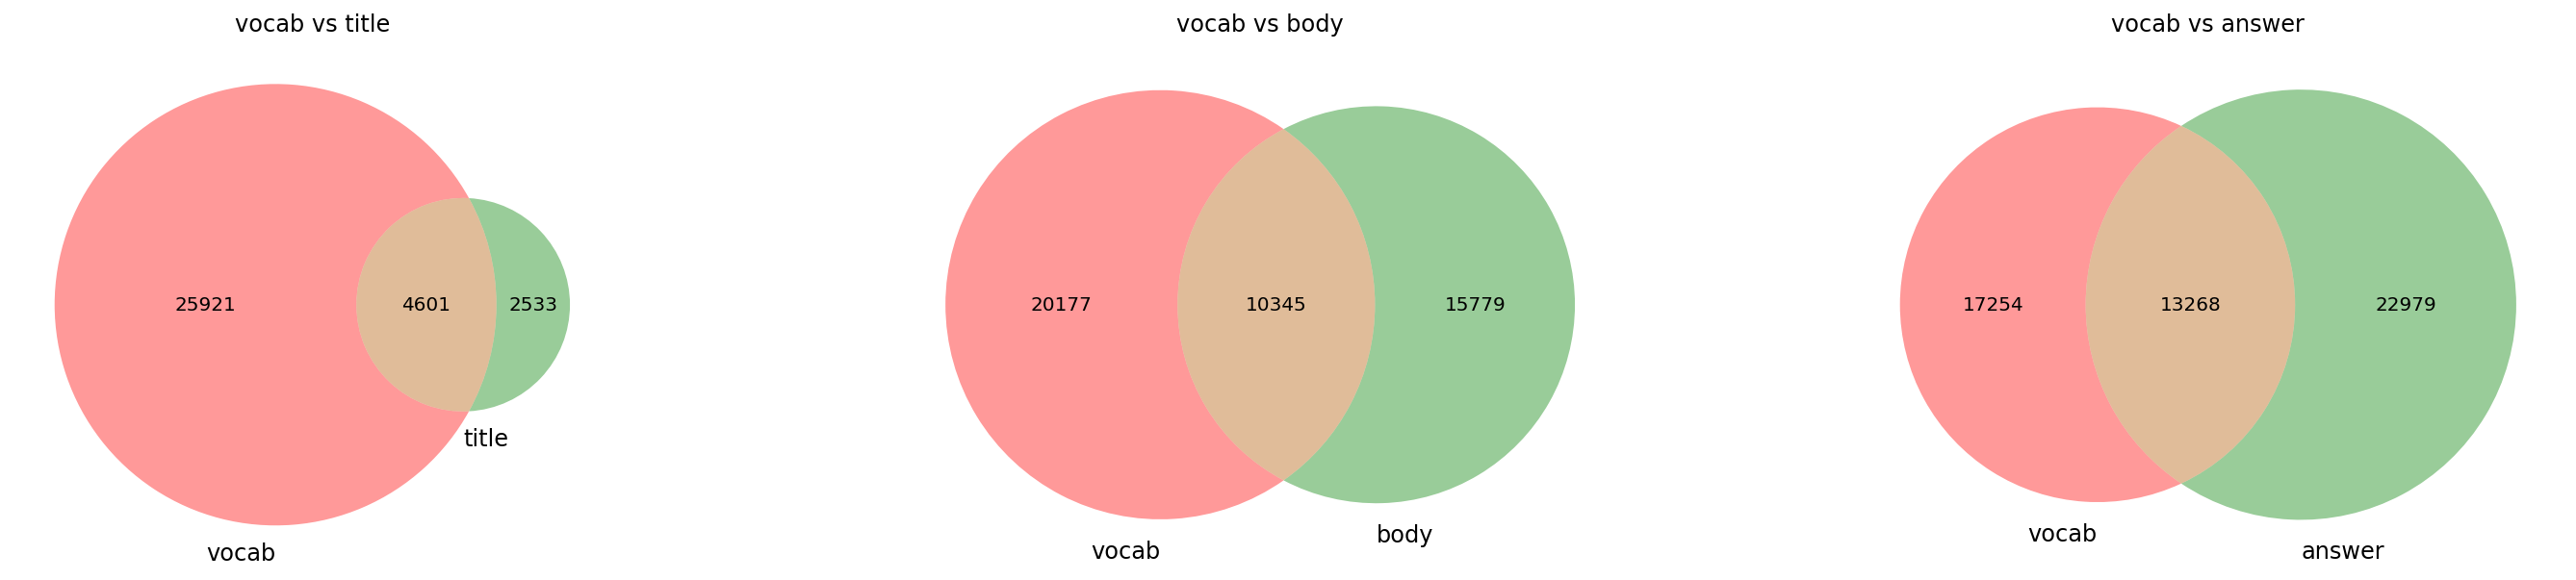

In [32]:
t, q, a = check_converge(bert_tokenizer_keys, trn_df)

In [33]:
# 専門用語が多そう, これは vocab にいれてもよいのでは？
tt = pd.Series(t).sort_values(ascending=False)
qq = pd.Series(q).sort_values(ascending=False)
aa = pd.Series(a).sort_values(ascending=False)

display(tt.loc[set(tt.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(qq.loc[set(qq.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))
display(aa.loc[set(aa.index) - bert_tokenizer_keys].sort_values(ascending=False).reset_index().head(100))

,index,0
0,jquery,54
1,javascript,51
2,ubuntu,45
3,url,34
4,mathbb,33
5,sharepoint,31
6,magento,31
7,mysql,30
8,delete,28
9,asp,26


,index,0
0,div,471
1,url,465
2,ubuntu,421
3,href,333
4,frac,326
5,js,325
6,src,223
7,mathbb,219
8,css,210
9,orf,206


,index,0
0,frac,519
1,nbsp,475
2,url,326
3,div,244
4,mathbb,206
5,sudo,167
6,usepackage,161
7,delete,154
8,cdot,153
9,config,153


In [34]:
_df = pd.concat([tt.loc[set(tt.index) - bert_tokenizer_keys], qq.loc[set(qq.index) - bert_tokenizer_keys], aa.loc[set(aa.index) - bert_tokenizer_keys]], axis=0).reset_index(drop=False).reset_index(drop=True)
_df.columns = ['word', 'count']
res_df = _df.groupby('word').sum().reset_index().sort_values('count', ascending=False)
res_df

,word,count
10169,frac,849
29082,url,825
7483,div,723
28399,ubuntu,599
17885,nbsp,577
...,...,...
14646,kingsland,1
14645,kinetics,1
14642,kindred,1
14640,kindmap,1


In [36]:
(res_df['count'] >= 5).sum(),(res_df['count'] >= 10).sum(),(res_df['count'] >= 20).sum(),(res_df['count'] >= 30).sum(),

(6934, 3155, 1330, 764)

In [41]:
import pickle

with open('../mnt/inputs/nes_info/trn_over_10_vocab.pkl', 'wb') as fout:
    pickle.dump(res_df.query('count >= 10').word.tolist(), fout)